<a href="https://colab.research.google.com/github/edwardmailyan/Autoencoders/blob/main/Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders

В этом ноутбуке мы будем тренировать автоэнкодеры кодировать лица людей. Для этого возьмем следующий датасет: "Labeled Faces in the Wild" (LFW) (http://vis-www.cs.umass.edu/lfw/). Код для скачивания и загрузки датасета написан за вас в файле get_dataset.py


# Vanilla Autoencoder (2 балла)

## Prepare the data


In [1]:
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
from time import time
from IPython.display import clear_output
import seaborn as sns

plt.style.use('ggplot')
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp drive/MyDrive/Autoencoders/get_dataset.py .

In [4]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from get_dataset import fetch_dataset
data, attrs = fetch_dataset(dimx=48, dimy=48)

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done



Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

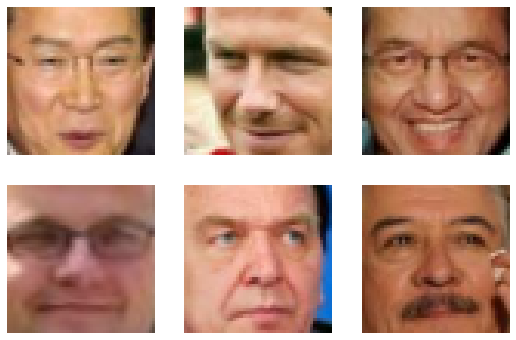

In [5]:
# <тут Ваш код>
from sklearn.model_selection import train_test_split
train_data, val_data, train_attrs, val_attrs = train_test_split(*(torch.from_numpy(data), attrs), test_size=0.25)

plt.figure(figsize=(9, 6))
for i in range(6):
  plt.subplot(2, 3, i+1)
  plt.axis('off')
  plt.imshow(train_data[i])

In [6]:
train_data[0].size()

torch.Size([48, 48, 3])

## Autoencoder
В этом разделе мы напишем и обучем обычный автоэнкодер.

Надеюсь, что к этому моменту вы уже почитали про автоэнкодеры и знаете, зачем они нужны и какова их архитектура. Если нет, то начните с этих ссылок: 

https://habr.com/ru/post/331382/ \\
https://towardsdatascience.com\intuitively-understanding-variational-autoencoders-1bfe67eb5daf



<img src="https://i.imgur.com/nVJAtMT.png" alt="Autoencoder">

Вот так выглядит автоэнкодер

In [7]:
dim_code = 200 # выберите размер латентного вектора, т.е. code, самой "узкой" части автоэнкодера
img_size = 12

In [8]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.reshape(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1, img_size, img_size)

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [9]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=4, stride=2, padding=1),
            nn.ELU()
        )
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=4, stride=2, padding=1),
            nn.ELU()
        )

        self.code = nn.Sequential(
            Flatten(),
            nn.Linear(16*12*12, dim_code),
            nn.ELU()
        )

        self.dec0 = nn.Sequential(
            nn.Linear(dim_code, 16*12*12),
            UnFlatten(),
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=4, padding=1, stride=2),
            nn.ELU()
        )
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=4, padding=1, stride=2),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        
        # <реализуйте forward проход автоэнкодера
        # в качестве ваозвращаемых переменных -- латентное представление картинки (latent_code) 
        # и полученная реконструкция изображения (reconstruction)>

        latent_code = self.encode(x)

        reconstruction = self.decode(latent_code)
        
        return reconstruction, latent_code

    def decode(self, z):
        dec0 = self.dec0(z)
        reconstruction = self.dec1(dec0)

        return reconstruction

    def encode(self, x):
        enc0 = self.enc0(x)
        enc1 = self.enc1(enc0)

        latent_code = self.code(enc1)

        return latent_code

    def attr_transfer_train(self, target_attr, current_attr):
        target_latent = torch.mean(self.encode(target_attr), dim=0)
        current_latent = torch.mean(self.encode(current_attr), dim=0)
        self.transfer_latent = target_latent - current_latent

    def transfer_attribute(self, data):
        latent = self.encode(data) + self.transfer_latent
        result = self.decode(latent)
        return result

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [11]:
# <тут Ваш код тренировки автоэнкодера>
def train(model, opt, loss_fn, epochs, data_tr, data_val):
  X_val= next(iter(data_val))
  history = []

  for epoch in range(epochs):
    print('* Epoch %d/%d' % (epoch+1, epochs))
    avg_loss = 0
    model.train()  # train mode

    for X_batch in data_tr:
      X_batch = X_batch.to(device)

      opt.zero_grad()

      Y_pred = model(X_batch)
      loss = loss_fn(Y_pred[0], X_batch)
      loss.backward()
      opt.step()

      avg_loss += loss/len(data_tr)

    print('loss: %f' % avg_loss)
    model.eval()

    Y_hat = model(X_val.cuda())[0].detach().cpu() # detach and put into cpu
    loss = loss_fn(Y_hat, X_val)

    history.append((avg_loss, loss))


    # Visualize tools
    clear_output(wait=True)
    plt.figure(figsize=(15,6))
    for k in range(6):
      plt.subplot(2, 6, k+1)
      plt.imshow(X_val[k].permute(1, 2, 0).numpy())
      plt.title('Real')
      plt.axis('off')

      plt.subplot(2, 6, k+7)
      plt.imshow(Y_hat[k].permute(1, 2, 0).numpy())
      plt.title('Output')
      plt.axis('off')

    plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
    plt.show()
  
  return history

In [12]:
def plot_losses(history):
  loss_tr, loss_val = zip(*history)
  plt.figure(figsize=(12, 12))
  plt.title('Model losses')
  plt.xlabel('Epoch')
  plt.plot(loss_tr, label='train')
  plt.plot(loss_val, label='val')
  plt.legend()

In [13]:
criterion = nn.MSELoss()

autoencoder = Autoencoder().to(device)

optimizer = optim.Adam(autoencoder.parameters())

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

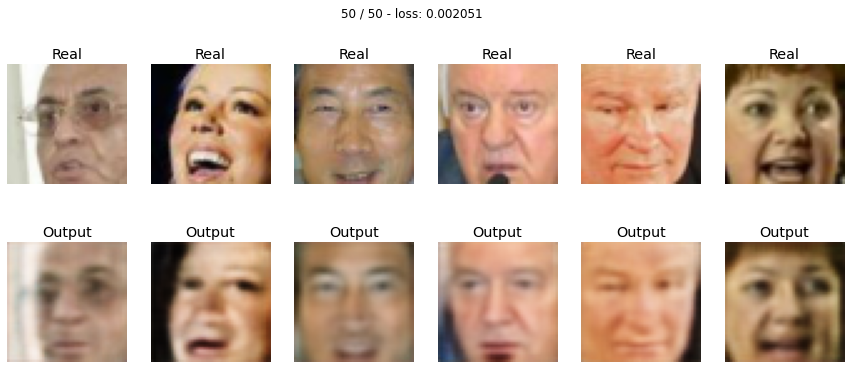

In [14]:
# < тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>
batch_size = 128

data_tr = data_utils.DataLoader(train_data.permute(0, 3, 1, 2).float(), batch_size=batch_size)
data_val = data_utils.DataLoader(val_data.permute(0, 3, 1, 2).float(), batch_size=batch_size)

loss = train(autoencoder, optimizer, criterion, 50, data_tr, data_val)

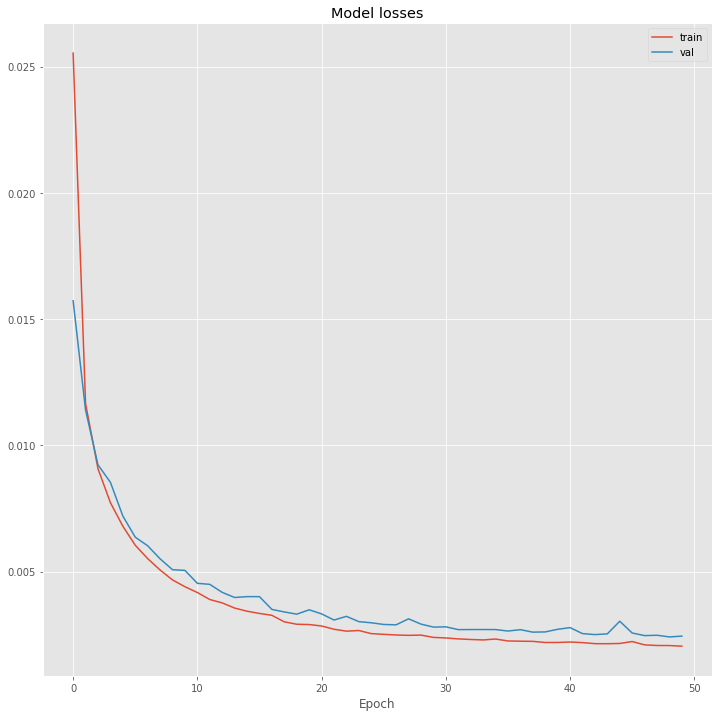

In [15]:
plot_losses(loss)

Not bad, right? 

## Sampling

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

#### If that doesn't work
Если вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как np.random.randn(25, <latent_space_dim>). А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как лаьентные векторы реальных фоток. Так что придется рандом подогнать.

In [16]:
def calculate_mean_std(model, data):
  data = torch.Tensor(np.rollaxis(data.numpy(),3,1)).to(device)
  latent = model.encode(data).detach().cpu()

  mean = torch.mean(latent, dim=0)
  std = torch.std(latent, dim=0)

  return mean, std

In [17]:
mean, std = calculate_mean_std(autoencoder, train_data.float())

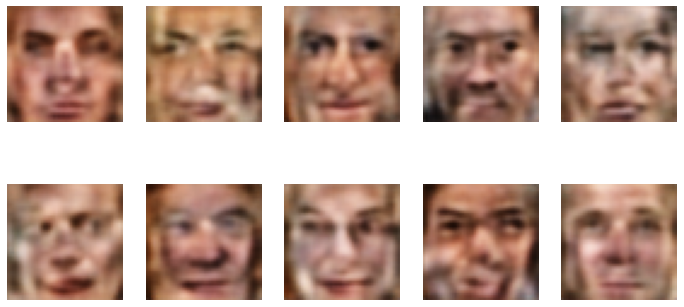

In [18]:
# сгенерируем 10 рандомных векторов размера latent_space
with torch.no_grad():
  z = std * np.random.randn(10, dim_code) + mean
  z = torch.Tensor(z.float())
  output = autoencoder.decode(z.to(device))
  # <выведите тут полученные картинки>
  plt.figure(figsize=(12, 6))
  for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.axis('off')
    plt.imshow(output[i].permute(1, 2, 0).detach().cpu())

## Congrats!

Time to make fun!

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1) Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15 сойдет) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2) Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3) Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

3) А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного чувака и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

------------------------------------------------
Для начала найдем нужные лица. Возьмем 20 картинок с улыбающимися людьми и 20 с "грустными".

In [19]:
# <а вот тут все это надо запрогать, да>
smile_ids = np.random.choice(list(attrs.loc[(attrs['Smiling'] > 2)].index), 20)

smile_data = data[smile_ids]

In [20]:
sad_ids = np.random.choice(list(attrs.loc[(attrs['Smiling'] < -2)].index), 20)

sad_data = data[sad_ids]

Посмотрим на одно из грустных лиц.

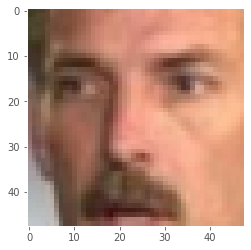

In [21]:
plt.grid(None)
plt.imshow(sad_data[4]);

После этого попробуем обучить нейросеть переносить улыбку (в принципе можно любой атрибут перевести таким же методом) на лица.

In [22]:
sad_data = torch.Tensor(np.rollaxis(sad_data, 3, 1))
smile_data = torch.Tensor(np.rollaxis(smile_data, 3, 1))

autoencoder.attr_transfer_train(smile_data.to(device), sad_data.to(device))

Дело за малым. Теперь возьмем 5 случайных изображений неулыбающихся людей, прогоним через нейронную сеть и посмотрим на получившийся результат.

In [23]:
random_sad_people = data[np.random.choice(list(attrs.loc[(attrs['Smiling'] < 0.1) & (attrs['Smiling'] > -0.5)].index), 5)]

In [24]:
random_sad_people = torch.Tensor(np.rollaxis(random_sad_people, 3, 1))

output = autoencoder.transfer_attribute(random_sad_people.to(device))

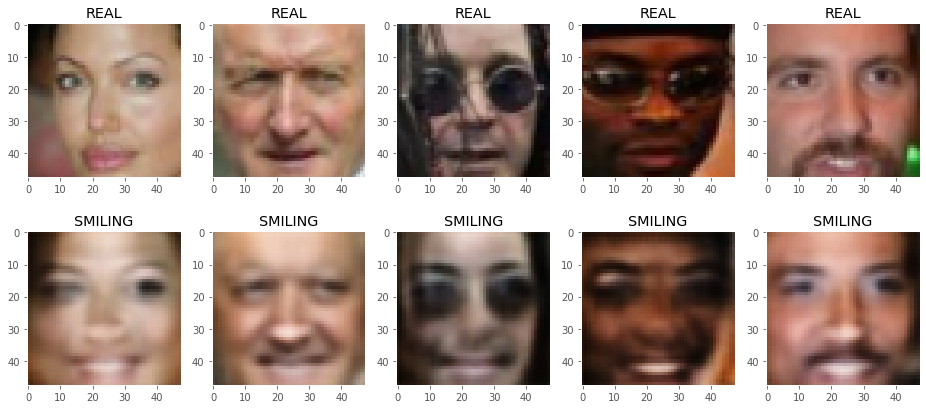

In [25]:
plt.figure(figsize=(16, 7))
for i in range(len(output)):
  plt.subplot(2, 5, i+1)
  plt.title('REAL')
  plt.grid(None)
  plt.imshow(random_sad_people[i].permute(1, 2, 0))
  plt.subplot(2, 5, i+6)
  plt.title('SMILING')
  plt.grid(None)
  plt.imshow(output[i].detach().cpu().permute(1, 2, 0))

Вуаля! Вы восхитительны!

---

---





Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в lwf_deepfinetuned.txt =)

# Variational Autoencoder. (3 балла) 

Представляю вам проапгрейдженную версию автоэнкодеров -- вариационные автоэнкодеры.

https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

In [26]:
img_size = 6

In [27]:
class VAE(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()
        # <определите архитектуры encoder и decoder
        # помните, у encoder должны быть два "хвоста", 
        # т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=4, padding=1, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, padding=1, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, padding=1, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=1),
            nn.ReLU(),
            Flatten()
        )

        self.enc_mu = nn.Linear(128 * 6 * 6, dim_code)
        self.enc_log = nn.Linear(128 * 6 * 6, dim_code) 
        self.dec = nn.Linear(dim_code, 128 * 6 * 6)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, padding=1, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, padding=1, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=in_channels, kernel_size=4, padding=1, stride=2),
            nn.Sigmoid()
        )

    def encode(self, x):
        # <реализуйте forward проход энкодера
        # в качестве ваозвращаемых переменных -- mu и logsigma>
        h = self.encoder(x)

        mu, logsigma = self.enc_mu(h), self.enc_log(h)

        return mu, logsigma
        
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            # <засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>
            std = logsigma.mul(0.5).exp_()
            # return torch.normal(mu, std)
            esp = torch.randn(*mu.size(), device=device)
            z = mu + std * esp
            return z
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z):
        # <реализуйте forward проход декодера
        # в качестве ваозвращаемой переменной -- reconstruction>
        z = self.dec(z)

        reconstruction = self.decoder(z)
        
        return reconstruction

    def forward(self, x):
        # <используя encode и decode, реализуйте forward проход автоэнкодера
        # в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        mu, logsigma = self.encode(x)
        latent = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(latent)

        return reconstruction, mu, logsigma

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [28]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.mean(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss
def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = F.binary_cross_entropy(reconstruction, x, reduction='mean')
    return loss

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) / (48 * 48) + log_likelihood(x, reconstruction) / batch_size

И обучим модель:

Определим новую функцию тренировки для нашей VAE

In [29]:
# <тут Ваш код тренировки автоэнкодера>
def train_vae(model, opt, loss_fn, epochs, data_tr, data_val):
  X_val= next(iter(data_val))
  history = []

  for epoch in range(epochs):
    print('* Epoch %d/%d' % (epoch+1, epochs))
    avg_loss = 0
    model.train()  # train mode
    for X_batch in data_tr:
      X_batch = X_batch.to(device)

      opt.zero_grad()

      Y_pred, mu, log = model(X_batch)

      loss = loss_fn(X_batch, mu, log, Y_pred)
      loss.backward()
      opt.step()

      avg_loss += loss/len(data_tr)

    print('loss: %f' % avg_loss)
    model.eval()

    Y_hat, mu, log = model(X_val.cuda()) # detach and put into cpu
    Y_hat = Y_hat.detach().cpu()
    mu = mu.detach().cpu()
    log = log.detach().cpu()
    loss = loss_fn(X_val, mu, log, Y_hat)

    history.append((avg_loss, loss))


    # Visualize tools
    clear_output(wait=True)
    plt.figure(figsize=(15,6))
    for k in range(6):
      plt.subplot(2, 6, k+1)
      plt.imshow(X_val[k].detach().cpu().permute(1, 2, 0), cmap='gray')
      plt.title('Real')
      plt.axis('off')

      plt.subplot(2, 6, k+7)
      plt.imshow(Y_hat[k].detach().cpu().permute(1, 2, 0), cmap='gray')
      plt.title('Output')
      plt.axis('off')

    plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
    plt.show()
  
  return history

In [30]:
criterion = loss_vae

vae = VAE(3).to(device)

optimizer = optim.Adam(vae.parameters(), lr=1e-3)

In [31]:
from torchsummary import summary
summary(vae, (3, 48, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]           1,568
       BatchNorm2d-2           [-1, 32, 24, 24]              64
              ReLU-3           [-1, 32, 24, 24]               0
            Conv2d-4           [-1, 64, 12, 12]          32,832
       BatchNorm2d-5           [-1, 64, 12, 12]             128
              ReLU-6           [-1, 64, 12, 12]               0
            Conv2d-7            [-1, 128, 6, 6]         131,200
       BatchNorm2d-8            [-1, 128, 6, 6]             256
              ReLU-9            [-1, 128, 6, 6]               0
           Conv2d-10            [-1, 128, 6, 6]          16,512
             ReLU-11            [-1, 128, 6, 6]               0
          Flatten-12                 [-1, 4608]               0
           Linear-13                  [-1, 200]         921,800
           Linear-14                  [

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

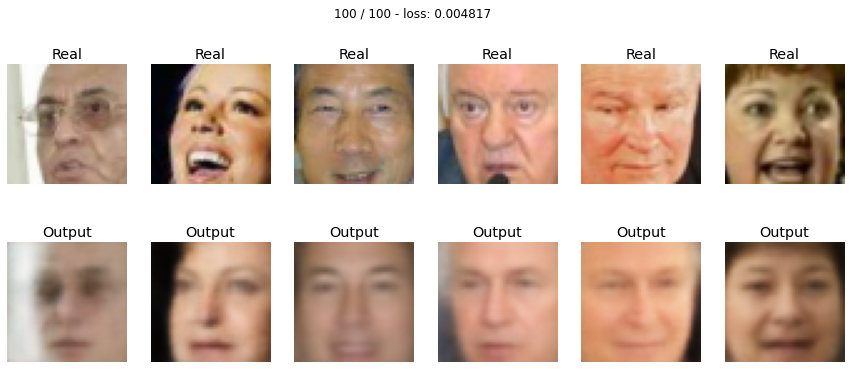

In [32]:
# <обучите модель, как и autoencoder, но на датасете MNIST>
history = train_vae(vae, optimizer, criterion, 100, data_tr, data_val);

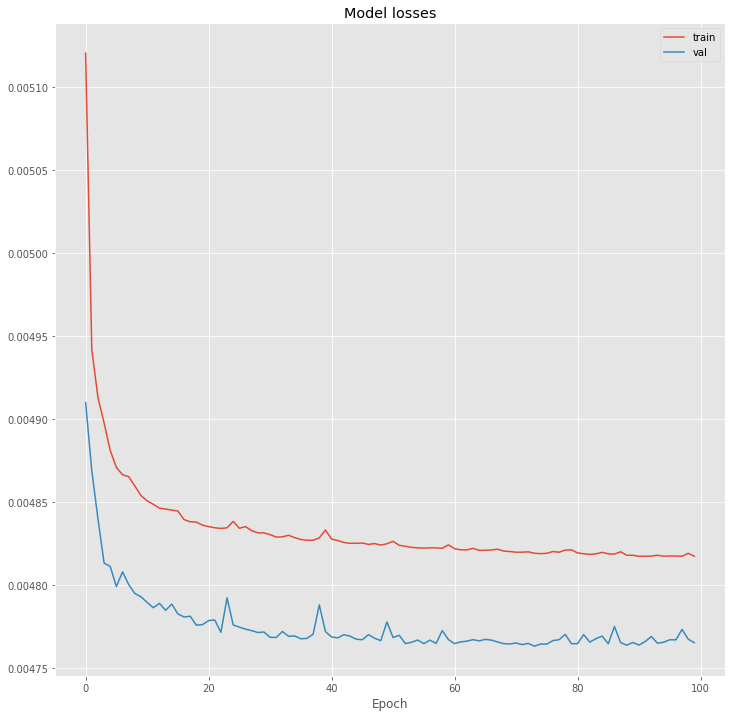

In [33]:
plot_losses(history)

And finally sample from VAE.

## Sampling

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

In [34]:
mu, std = vae.encode(train_data.permute(0, 3, 1, 2).float().to(device))
mu = mu.mean().detach().cpu()
std = std.mean().mul(0.5).exp_().detach().cpu()

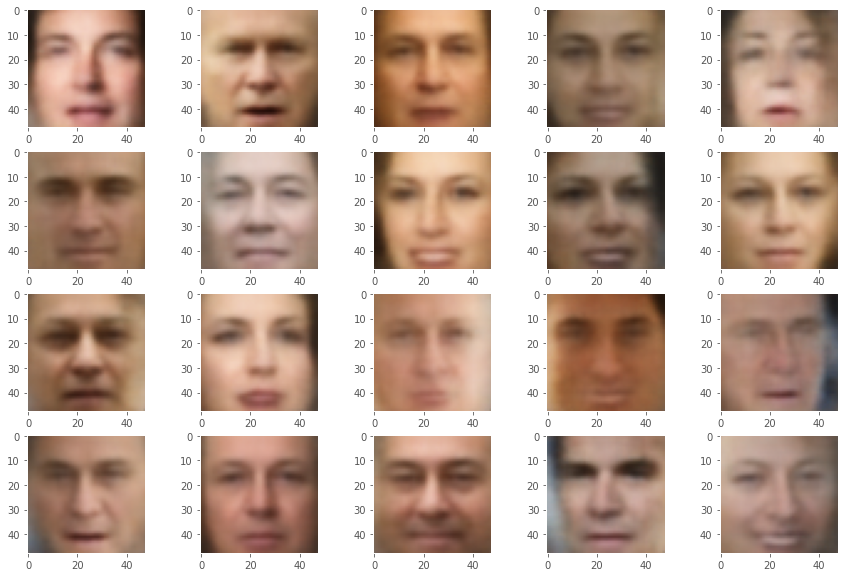

In [35]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
with torch.no_grad():
  z = np.array([np.random.normal(mu, std, dim_code) for i in range(20)])
  z = torch.Tensor(z).to(device)
  output = vae.decode(z) # <скормите z декодеру>
  # <выведите тут полученные картинки>
  plt.figure(figsize=(15, 10))
  for i in range(5):
    plt.subplot(4, 5, i+1)
    plt.grid(None)
    plt.imshow((output[i].detach().cpu().permute(1, 2, 0)))
    plt.subplot(4, 5, i+6)
    plt.grid(None)
    plt.imshow((output[i+5].detach().cpu().permute(1, 2, 0)))
    plt.subplot(4, 5, i+11)
    plt.grid(None)
    plt.imshow((output[i+10].detach().cpu().permute(1, 2, 0)))
    plt.subplot(4, 5, i+16)
    plt.grid(None)
    plt.imshow((output[i+15].detach().cpu().permute(1, 2, 0)))

## Latent Representation

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы лиц в пространстве. 

Плюс давайте сделаем такую вещь: у вас есть файл с атрибутами lwf_deepfinetuned.txt, который скачался вместе с базой картинок. Там для каждой картинки описаны атрибуты картинки (имя человека, его пол, цвет кожи и т.п.). Когда будете визуализировать точки латентного пространства на картинке, возьмите какой-нибудь атрибут и покрасьте точки в соответствии со значем атрибута, соответствующего этой точке. 

Например, возьмем атрибут "пол". Давайте покрасим точки, которые соответствуют картинкам женщин, в один цвет, а точки, которые соответствуют картинкам мужчин -- в другой.

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю TSNE (есть в sklearn) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью matplotlib.scatter, покрасить разными цветами точки, соответствующие картинкам с разными атрибутами.

In [36]:
# <ваш код получения латентных представлений, применения TSNE и визуализации>
from sklearn.manifold import TSNE
with torch.no_grad():
  vae.eval()
  output, mu, std = vae(val_data.permute(0, 3, 1, 2).float().to(device))
X_embedded = TSNE(n_components=2).fit_transform(mu.detach().cpu())

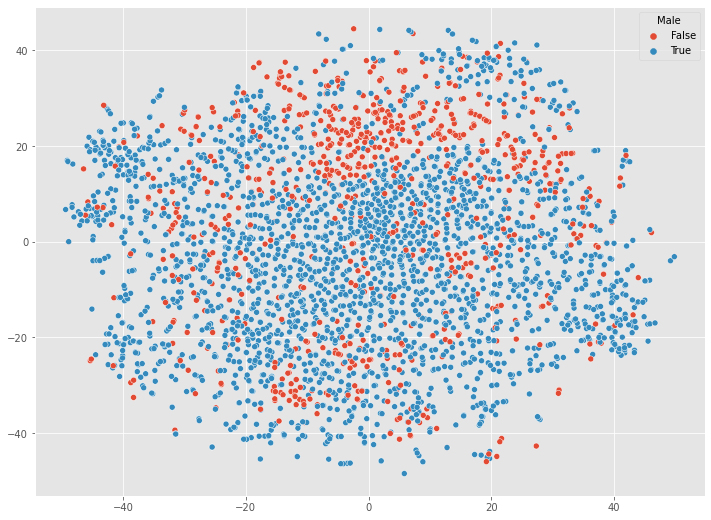

In [37]:
import warnings
warnings.filterwarnings("ignore")

plt.figure(figsize=(12, 9))
sns.scatterplot(X_embedded[:, 0], X_embedded[:, 1], hue=val_attrs['Male'] >= 0)
plt.legend(title='Male');

Что вы думаете о виде латентного представления?

## Congrats v2.0!

# Conditional VAE (2 балла)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот мне понадобилось сгенерировать цифру 8. И я подставляю разные варианты шума, и все никак не генерится восьмерка -- у меня получаются то пятерки, то тройки, то четверки. Гадость(

  Хотелось бы добавить к нашему AE функцию "выдай мне пожалуйста рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).
  Типа я такая говорю "выдай мне случайную восьмерку" и оно генерит случайную восьмерку!

Conditional AE -- так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части проекта мы научимся такие обучать.

## Архитектура

На картинке ниже представлена архитектура простого Conditional AE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера есть конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). Первый слой декодера есть конкатенация латентного вектора и информации о классе.


![alt text](https://i.ibb.co/2tsWknB/Screen-Shot-2020-01-15-at-9-02-15-PM.png)



На всякий случай: это VAE, то есть, latent у него состоит из mu и sigma все еще.

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

### P.S.
Можно ередавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

### Датасет
Здесь я предлагаю вам два вариана. Один попроще, другой -- посложнее, но поинтереснее =)

1. Использовать датасет MNIST (http://yann.lecun.com/exdb/mnist/). Обучать conditional VAE на этом датасете, condition -- класс цифры. 

2. Использовать датасет лиц, с которым мы игрались выше. Condition -- пол/раса/улыбки/whatever из lfw_deepfinetuned.txt. 

Почему второй вариант "посложнее" -- потому что я сама еще не знаю, получится ли такой CVAE с лицами или нет =) Вы -- исследователи! (не ну это же проект, так и должно быть)

In [47]:
# <тут ваш код объявления CVAE, лосса, оптимизатора и тренировки>

def one_hot(labels, class_size):
    targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return targets.to(device)


class CVAE(nn.Module):
    def __init__(self, feature_size, class_size):
        super(CVAE, self).__init__()
        self.feature_size = feature_size
        self.class_size = class_size

        # encode
        self.fc1  = nn.Linear(feature_size + class_size, 400)
        self.fc21 = nn.Linear(400, dim_code)
        self.fc22 = nn.Linear(400, dim_code)

        # decode
        self.fc3 = nn.Linear(dim_code + class_size, 400)
        self.fc4 = nn.Linear(400, feature_size)

        self.elu = nn.ELU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x, c): 
        inputs = torch.cat([x, c], 1)
        h1 = self.elu(self.fc1(inputs))
        z_mu = self.fc21(h1)
        z_var = self.fc22(h1)
        return z_mu, z_var

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            # <засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>
            std = logsigma.mul(0.5).exp_()
            # return torch.normal(mu, std)
            esp = torch.randn(*mu.size(), device=device)
            z = mu + std * esp
            return z
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z, c): 
        inputs = torch.cat([z, c], 1) 
        h3 = self.elu(self.fc3(inputs))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x, c):
        mu, logvar = self.encode(x.view(-1, 48*48*3), c)
        z = self.gaussian_sampler(mu, logvar)
        return self.decode(z, c).view(-1, 3, 48, 48), mu, logvar

In [48]:
attrs.columns

Index(['Male', 'Asian', 'White', 'Black', 'Baby', 'Child', 'Youth',
       'Middle Aged', 'Senior', 'Black Hair', 'Blond Hair', 'Brown Hair',
       'Bald', 'No Eyewear', 'Eyeglasses', 'Sunglasses', 'Mustache', 'Smiling',
       'Frowning', 'Chubby', 'Blurry', 'Harsh Lighting', 'Flash',
       'Soft Lighting', 'Outdoor', 'Curly Hair', 'Wavy Hair', 'Straight Hair',
       'Receding Hairline', 'Bangs', 'Sideburns', 'Fully Visible Forehead',
       'Partially Visible Forehead', 'Obstructed Forehead', 'Bushy Eyebrows',
       'Arched Eyebrows', 'Narrow Eyes', 'Eyes Open', 'Big Nose',
       'Pointy Nose', 'Big Lips', 'Mouth Closed', 'Mouth Slightly Open',
       'Mouth Wide Open', 'Teeth Not Visible', 'No Beard', 'Goatee',
       'Round Jaw', 'Double Chin', 'Wearing Hat', 'Oval Face', 'Square Face',
       'Round Face', 'Color Photo', 'Posed Photo', 'Attractive Man',
       'Attractive Woman', 'Indian', 'Gray Hair', 'Bags Under Eyes',
       'Heavy Makeup', 'Rosy Cheeks', 'Shiny Skin', 'Pa

In [49]:
cols = ['Male', 'Smiling', 'Mustache', 'Heavy Makeup', 'Black']

In [50]:
train_attrs_loader = data_utils.DataLoader(torch.Tensor(train_attrs[cols].values.astype(np.float64)), batch_size=batch_size)
val_attrs_loader = data_utils.DataLoader(torch.Tensor(val_attrs[cols].values.astype(np.float64)), batch_size=batch_size)

In [51]:
from itertools import cycle

def train_cvae(model, opt, loss_fn, epochs, data_tr, data_val):
  X_val = next(iter(data_val))
  Y_val = next(iter(val_attrs_loader))

  history = []


  for epoch in range(epochs):
    print('* Epoch %d/%d' % (epoch+1, epochs))
    avg_loss = 0
    iterator = cycle(train_attrs_loader)
    model.train()  # train mode
    for X_batch in data_tr:
      X_batch = X_batch.to(device)
      Y_batch = next(iterator)

      opt.zero_grad()

      Y_pred, mu, log = model(X_batch, Y_batch.cuda())

      loss = loss_fn(X_batch, mu, log, Y_pred)
      loss.backward()
      opt.step()

      avg_loss += loss/len(data_tr)

    print('loss: %f' % avg_loss)
    model.eval()

    Y_hat, mu, log = model(X_val.cuda(), Y_val.cuda()) # detach and put into cpu
    Y_hat = Y_hat.detach().cpu()
    mu = mu.detach().cpu()
    log = log.detach().cpu()
    loss = loss_fn(X_val, mu, log, Y_hat)

    history.append((avg_loss, loss))

    # Visualize tools
    clear_output(wait=True)
    plt.figure(figsize=(15,6))
    for k in range(6):
      plt.subplot(2, 6, k+1)
      plt.imshow(X_val[k].detach().cpu().permute(1, 2, 0), cmap='gray')
      plt.title('Real')
      plt.axis('off')

      plt.subplot(2, 6, k+7)
      plt.imshow(Y_hat[k].detach().cpu().permute(1, 2, 0), cmap='gray')
      plt.title('Output')
      plt.axis('off')

    plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
    plt.show()

  return history

In [52]:
cvae = CVAE(48*48*3, len(cols)).to(device)

optimizer = optim.Adam(cvae.parameters(), lr=1e-3)

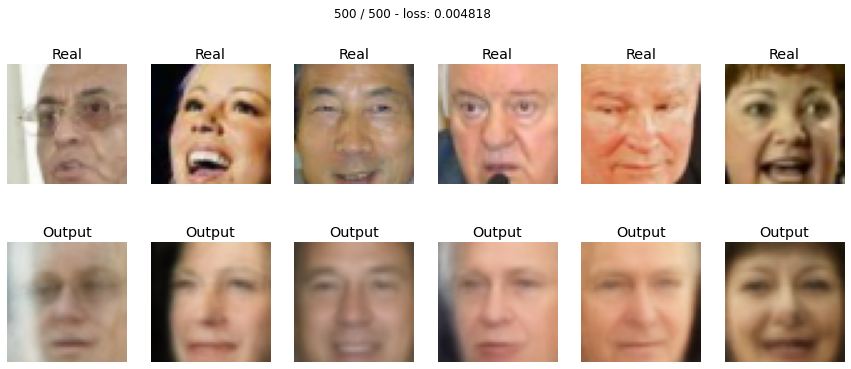

In [53]:
history = train_cvae(cvae, optimizer, loss_vae, 500, data_tr, data_val)

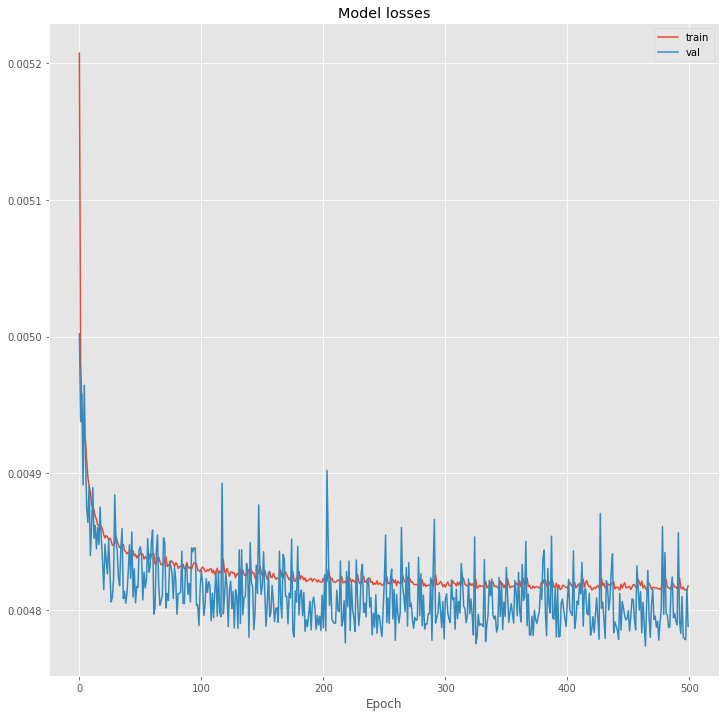

In [54]:
plot_losses(history)

## Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора картинки цифры 5 и 7, а для лиц людей -- восстановить лицо улыбающегося и хмурого человека или лица людей разного пола (смотря на чем был ваш кондишен)

Попробуем сгенерировать лица улыбающихся девушек с макияжем.

In [55]:
cols

['Male', 'Smiling', 'Mustache', 'Heavy Makeup', 'Black']

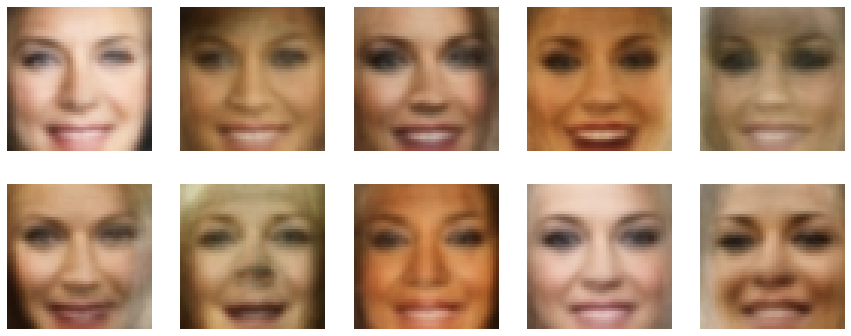

In [56]:
# <тут нужно научиться сэмплировать из декодера цифры определенного класса>
c = 4 * torch.rand(10, len(cols)).cuda() - 2

for i in range(len(c)):
  c[i, 0] = -np.random.random() - 1
  c[i, 1] = np.random.random() + 1
  c[i, 2] = -2
  c[i, 3] = np.random.random() + 1

sample = torch.randn(10, dim_code).to(device)
sample = cvae.decode(sample, c).view(-1, 3, 48, 48).detach().cpu()

plt.figure(figsize=(15, 6))
for i in range(len(sample)):
  plt.subplot(2, 5, i+1)
  plt.imshow(sample[i].permute(1, 2, 0))
  plt.grid(None)
  plt.axis('off')

Splendid! Вы великолепны!

Ну круто же, ну?

## Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

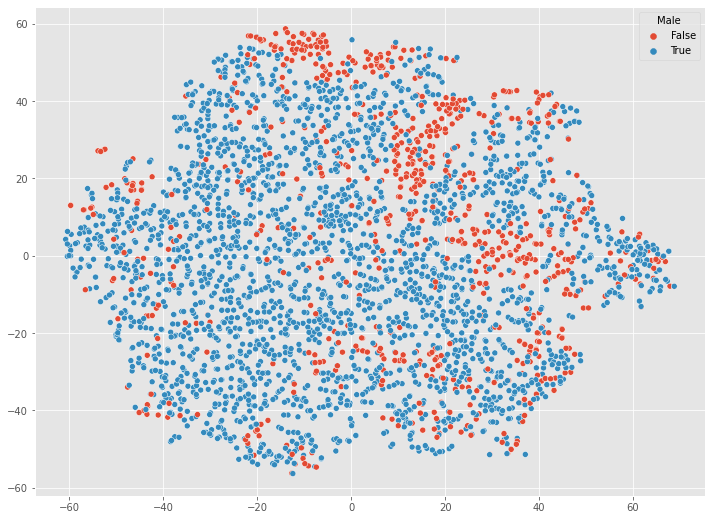

In [57]:
# <ваш код получения латентных представлений, применения TSNE и визуализации>
labels = torch.Tensor(val_attrs[cols].values.astype(np.float64))

with torch.no_grad():
  cvae.eval()
  output, mu, std = cvae(val_data.float().to(device), labels.to(device))
X_embedded = TSNE(n_components=2).fit_transform(mu.detach().cpu())

plt.figure(figsize=(12, 9))
sns.scatterplot(X_embedded[:, 0], X_embedded[:, 1], hue=val_attrs['Male'] > 0)
plt.legend(title='Male');

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

# BONUS 1: Image Morphing (1 балл) 

<a href="https://ibb.co/rxr9YgL"><img src="https://i.ibb.co/D92dhN6/1-6y-Okto2-BUp-ONJpk5x-LRMtw.png" alt="1-6y-Okto2-BUp-ONJpk5x-LRMtw" border="0"></a>

Предлагаю вам поиграться не только с улыбками, но и с получением из одного человека другого!

План:
1. Берем две картинки разных людей из датасета
2. Получаем их латентные представления X и Y
3. Складываем латентные представления с коэффициентом $\alpha$:
  $$\alpha X + (1-\alpha) Y$$
  где $\alpha$ принимает несколько значений от 0 до 1 
4. Визуализируем, как один человек превращается в другого!

In [58]:
img_size = 12

In [59]:
# <тут ваш код>
def image_morphing(model, first_img, second_img):
  with torch.no_grad():
    alpha = 0.1
    first_latent = model.encode(first_img)
    second_latent = model.encode(second_img)


    plt.figure(figsize=(24, 2))
    for i in range(0, 11):
      new_latent = alpha*i*second_latent + (1-alpha*i)*first_latent
      new_image = model.decode(new_latent)[0].detach().cpu().permute(1, 2, 0)
      plt.subplot(1, 11, i+1)
      plt.title('Alpha = {: .2}'.format(alpha*i))
      plt.grid(None)
      plt.axis('off')
      plt.imshow(new_image.numpy())
    plt.show()

In [60]:
first = torch.Tensor(np.rollaxis(data[None, np.random.randint(len(data))], 3, 1)).to(device)
second = torch.Tensor(np.rollaxis(data[None, np.random.randint(len(data))], 3, 1)).to(device)

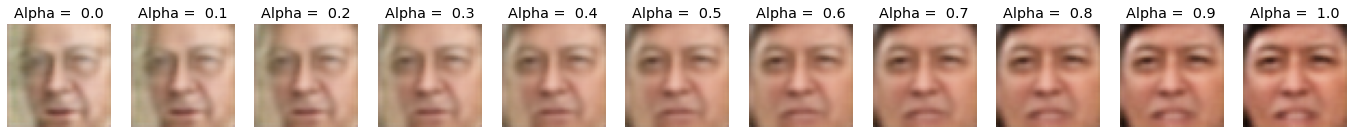

In [61]:
image_morphing(autoencoder, first, second)

# BONUS 2: Denoising (2 балла) 

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них это бонусное задание.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для того, чтобы поставить эксперимент, нужно взять ваш любимый датасет (датасет лиц или MSE с прошлых заданий или любой другой) и сделать копию этого датасета с шумом. 

В питоне шум можно добавить так:

In [62]:
noise_factor = 0.2
train_noisy = train_data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_data.shape) 
test_noisy = val_data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=val_data.shape) 

In [63]:
noisy_loader = torch.utils.data.DataLoader(train_noisy.permute(0, 3, 1, 2).float(), batch_size=batch_size, drop_last=True)
target_loader = torch.utils.data.DataLoader(train_data.permute(0, 3, 1, 2).float(), batch_size=batch_size, drop_last=True)

In [64]:
# <тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудтье разбить на train/test!>
criterion = nn.MSELoss()
model = Autoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 300

for i in range(epochs):
    avg_loss = 0
    model.train()  # train mode

    iterator = cycle(target_loader)

    for X_batch in noisy_loader:
      X_batch = X_batch.to(device)

      Y_batch = next(iterator).to(device)

      optimizer.zero_grad()

      Y_pred = model(X_batch)
      loss = criterion(Y_pred[0], Y_batch)

      loss.backward()
      optimizer.step()

      avg_loss += loss/len(target_loader)

    clear_output(wait=True)
    print('* Epoch %d/%d --- train loss: %f' % (i+1, epochs, avg_loss))

* Epoch 300/300 --- train loss: 0.001945


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


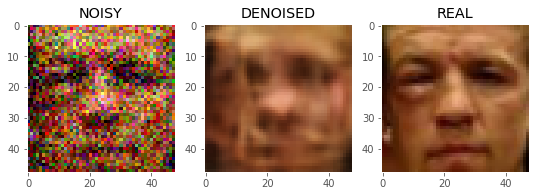

In [65]:
# <тут проверка, как AE убирает щум с тестовых картинок. Надеюсь, все получилось =)>
with torch.no_grad():
  model.eval()
  pred = model(test_noisy.permute(0, 3, 2, 1).float().to(device))[0]
  
  id = np.random.randint(len(test_noisy))

  plt.figure(figsize=(9, 3))

  plt.subplot(1, 3, 1)
  plt.imshow(test_noisy[id])
  plt.grid(None)
  plt.title('NOISY')

  plt.subplot(1, 3, 2)
  plt.imshow(np.transpose(pred.detach().cpu()[id]))
  plt.grid(None)
  plt.title('DENOISED')
  
  plt.subplot(1, 3, 3)
  plt.imshow(val_data[id])
  plt.grid(None)
  plt.title("REAL")

## Бонус 2.1: Occlusion (+еще 1 балл)

<a href="https://imgbb.com/"><img src="https://i.ibb.co/wYrKtQY/Screen-Shot-2020-06-04-at-5-06-35-PM.png" alt="Screen-Shot-2020-06-04-at-5-06-35-PM" border="0" width="300" height="300"></a>

Автоэнкодерами можно не только убирать шум, но и восстанавливать части картинки, которые чем-то закрыты! 

Эксперимент здесь такой: вместо наложения шума на картинку, "закрываем" часть картинки заплаткой и тренируем AE/VAE восстанавливать закрытую часть картинки.

Важно, чтобы заплатка была не очень большая. 

In [66]:
import cv2

def add_occlusion(imgs):
  for i in range(len(imgs)):
    occluded = cv2.rectangle(imgs[i], (20, 20), (30, 35), (255, 255, 255), cv2.FILLED)

In [67]:
# <тут ваш код обучения автоэнкодера на occluded (простите, не знаю, как это сказать по-русски) картинках. Не забудтье разбить на train/test!>
criterion = nn.MSELoss()
model = Autoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# prepare the data
occluded_data = np.copy(train_data)
add_occlusion(occluded_data)

occluded_val = np.copy(val_data)
add_occlusion(occluded_val)
occluded_val = torch.Tensor(occluded_val)

occluded_val = torch.utils.data.DataLoader(torch.Tensor(occluded_val).permute(0, 3, 1, 2).float(), batch_size=batch_size, drop_last=True)

occluded_loader = torch.utils.data.DataLoader(torch.Tensor(occluded_data), batch_size=batch_size, drop_last=True)
target_loader = torch.utils.data.DataLoader(train_data.permute(0, 3, 1, 2).float(), batch_size=batch_size, drop_last=True)


for i in range(epochs):
    avg_loss = 0
    model.train()  # train mode

    iterator = cycle(target_loader)

    for X_batch in occluded_loader:
      X_batch = X_batch.permute(0, 3, 1, 2)

      Y_batch = next(iterator)

      optimizer.zero_grad()

      Y_pred = model(X_batch.to(device))
      loss = criterion(Y_pred[0], Y_batch.to(device))

      loss.backward()
      optimizer.step()

      avg_loss += loss/len(target_loader)

    clear_output(wait=True)
    print('* Epoch %d/%d --- loss: %f' % (i+1, epochs, avg_loss))

* Epoch 300/300 --- loss: 0.001496


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


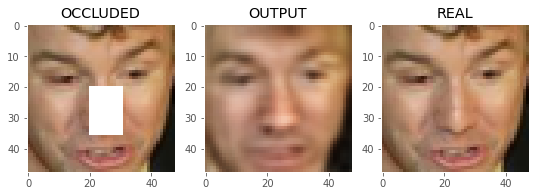

In [68]:
with torch.no_grad():
  model.eval()
  imgs = next(iter(occluded_val))
  pred = model(imgs.to(device))[0]
  
  id = np.random.randint(len(imgs))

  plt.figure(figsize=(9, 3))

  plt.subplot(1, 3, 1)
  plt.imshow(imgs[id].permute(1, 2, 0))
  plt.grid(None)
  plt.title('OCCLUDED')

  plt.subplot(1, 3, 2)
  plt.imshow(pred.detach().cpu()[id].permute(1, 2, 0))
  plt.grid(None)
  plt.title('OUTPUT')
  
  plt.subplot(1, 3, 3)
  plt.imshow(val_data[id])
  plt.grid(None)
  plt.title("REAL");

# Bonus 3: Image Retrieval (1 балл)

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest (sklearn.neighbors.LSHForest), например, с n_estimators=50
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [69]:
codes = vae.encode(train_data.permute(0, 3, 1, 2).float().to(device))[0].detach().cpu()

In [70]:
codes.shape

torch.Size([9857, 200])

In [71]:
# обучаем LSHForest
from sklearn.neighbors import NearestNeighbors
neighs = NearestNeighbors(n_neighbors=5).fit(codes)

In [72]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = vae.encode(image)[0].detach().cpu()
    
  (distances,),(idx,) = neighs.kneighbors(code, n_neighbors=n_neighbors)

  return distances, train_data[idx]

In [73]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[15,10])
    plt.subplot(3,4,1)
    plt.imshow((image[0].cpu().permute(1, 2, 0).numpy()))
    plt.title("Original image")
    plt.grid(None)
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy())
        plt.title("Dist=%.3f"%distances[i])
        plt.grid(None)
        
    plt.show()

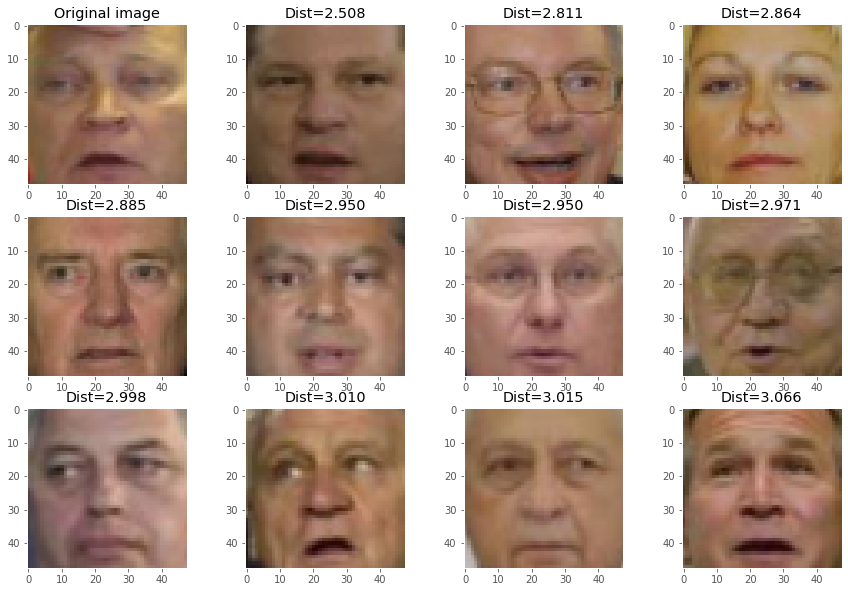

In [74]:
# <тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>
show_similar(val_data[None, np.random.randint(len(val_data))].permute(0, 3, 1, 2).to(device).float())

# Bonus 4: Телеграм-бот (3 балла)

Вы можете написать телеграм-бота с функционалом AE. Например, он может добавлять к вашей фотографии улыбку или искать похожие на ваше лицо лица среди лиц датасета. 

Код бота должно быть можно проверить!

# Эпилог

здесь мы рассмотрели не все применения автоэнкодеров. Еще есть, например:

-- поиск аномалий
-- дополнение отсутствующих частей картины
-- работа с sequential данными (например, временными рядами)
-- гибриды ГАН+АЕ, которые активно изучаются в последнее время
-- использование латентных переменных АЕ в качестве фичей
...

Они не были частью этого проекта, потому что для их реализации пришлось бы больше возиться с датасетами. 

Но! Если вы хотите, вы, конечно, всегда можете реализовать еще что-то и получить за это еще допбаллы.

Надеюсь, вам понравилось!